## Imports

In [1]:
import numpy as np
import networkx as nx
from qibo import matrices, optimizers
from qibo.hamiltonians import Hamiltonian
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## MAXcut Hamiltonian

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph)

    ham = np.zeros(shape=(2**nqubits,2**nqubits), dtype=np.complex128)
    for i in range(nqubits):
        for j in range(nqubits):
            h = np.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = np.kron(h, matrices.Z)
                else:
                    h = np.kron(h, matrices.I)            
            M = np.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    matrix = - 1/norm * ham
    
    return Hamiltonian(nqubits, matrix, numpy=True)


def Qu(beta, r, eps=1e-3):
    return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)

## Optimization class

In [163]:
class FragmentedQuITE:
    
    def __init__(self, hamiltonian, r, b, query, eps=1e-3):
        """Test function for optimization."""
        self.n = hamiltonian.nqubits
        self.energy = np.real(hamiltonian.eigenvalues())
        self.lmin = np.min(self.energy)
        self.lmax = np.max(self.energy)
        self.r = r
        self.b = b
        self.query = query
        self.eps = eps

    def minimize(self, schedule, initial_parameters=None, method='BFGS', options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            return np.diff([schedule(step/self.r, p) for step in range(1, self.r+1)])
        
        con1 = {'type': 'ineq', 'fun': derivative}
        m = minimize(lambda p, _: self.compute_query(p, schedule),
                        initial_parameters, 
                        method, options=options, constraints=con1)  
        return m.fun, m.x        
        
    def compute_query(self, params, schedule):
        """Compute query optimization."""
        beta = np.array([ self.b*schedule(step/self.r, params) for step in range(1, self.r+1)])
        delta_l = (self.lmax-self.lmin)/2
        Qbeta = np.ceil(self.query(np.hstack([beta[0], np.diff(beta)])*delta_l*np.e/2, self.r, self.eps))
        Zbeta = np.sum(np.exp(-beta.reshape(-1,1)[:-1] * self.energy.reshape(1,-1)), axis=1)
        Psbeta = Zbeta / np.exp(-beta[:-1]*self.lmin) / 2**self.n
        Qr = np.sum(Psbeta * Qbeta[1:]) + Qbeta[0]
        Zbeta = np.sum(np.exp(-beta[r-1]*self.energy))
        Psbeta = Zbeta / np.exp(-beta[r-1]*self.lmin) / 2**self.n    
        Q = 1/Psbeta * Qr
        return Q

    def reference_query(self):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t)

## Example

Reference value: 55.14033784355961
Optimized value: 54.34097674815433
Best params: [-1.07142847]
Reference value: 55.14033784355961
Optimized value: 51.17589533535576
Best params: [-5.38043234  2.44565084]
Reference value: 55.14033784355961
Optimized value: 47.05174305297194
Best params: [-14.84095793  15.31807799  -5.65011056]


<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)
<ipython-input-2-fc673c59eb0a>:28: RuntimeWarning: invalid value encountered in log
  return beta + np.log(r/eps) / np.log(np.e + np.log(r/eps)/beta)


Reference value: 55.14033784355961
Optimized value: 43.496917338670116
Best params: [-32.1653551   55.56680409 -45.57110585  14.28545002]


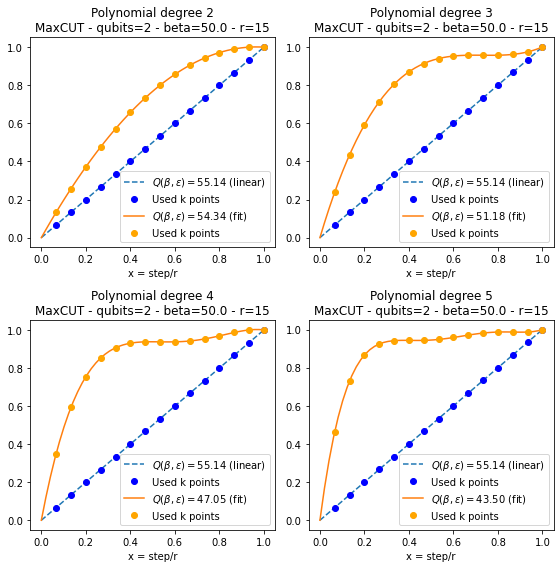

In [183]:
# setup
nqubits = 2
r = 15
beta = 50

model = FragmentedQuITE(maxcut(nqubits, norm=40.0, random_graph=True), r, beta, Qu)

def myschedule(t, params):
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f
    

plt.figure(figsize=(8,8))
for d in range(4):
    plt.subplot(2,2,d+1)
    plt.tight_layout()
    initial_guess = np.zeros(d+1)
    initial_guess[0] = 0.1
    result, params = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    method='COBYLA', options={'maxiter':50000})
    reference = model.reference_query()
    print('Reference value:', reference)
    print('Optimized value:', result)
    print('Best params:', params)

    # plot
    x = np.linspace(0,1,50)
    xr = np.array(range(1,r+1))/r
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    plt.plot(x, [i for i in x], '--', label=r'$Q(\beta,\epsilon)=%.2f$ (linear)' % reference);
    plt.plot(xr, xr, 'o', color='blue', label='Used k points')
    plt.plot(x, [myschedule(i, params) for i in x], label=r'$Q(\beta,\epsilon)=%.2f$ (fit)' % result);
    plt.plot(xr,[myschedule(ixr, params) for ixr in xr], 'o', color='orange', label='Used k points')
    plt.xlabel('x = step/r')
    plt.legend();